# *Stop Sign Recognizer

In [76]:
# 导入数据处理所需的库
import numpy as np
import pandas as pd
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# 导入TensorFlow和相关库
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 检查TensorFlow版本
print(tf.__version__)


2.12.0


## Assigning Path for Dataset

In [77]:
# 数据集的基础路径
base_path = '/Users/zayn/Downloads/stop-train'  # 请替换为您数据集的实际路径

# 图像文件夹的路径
images_path = os.path.join(base_path, 'images')

# 注释文件夹的路径
annotations_path = os.path.join(base_path, 'annotations')

# 训练集和验证集列表文件的路径
train_list_path = os.path.join(base_path, 'train.txt')
val_list_path = os.path.join(base_path, 'val.txt')


## load data


In [78]:
def scale_bbox(bbox, target_size):
    """
    将边界框坐标归一化到 [0, 1] 范围内。
    :param bbox: 边界框坐标 (xmin, ymin, xmax, ymax)
    :param target_size: 目标图像尺寸 (width, height)
    :return: 归一化后的边界框坐标
    """
    width, height = target_size
    xmin, ymin, xmax, ymax = bbox
    return [xmin / width, ymin / height, xmax / width, ymax / height]


In [79]:
def pad_bboxes(bboxes, max_boxes=5):
    """
    确保每个图像具有固定数量的边界框，如果不足则用零填充。
    :param bboxes: 边界框列表的列表（每个内部列表代表一个图像的边界框）
    :param max_boxes: 每个图像的最大边界框数量
    :return: 填充后的边界框数组
    """
    padded_bboxes = []
    for box_list in bboxes:
        # 计算需要添加的零填充边界框的数量
        padding_count = max_boxes - len(box_list)
        # 创建零填充边界框
        padding = [[0, 0, 0, 0] for _ in range(padding_count)]
        # 将原始边界框和零填充边界框合并
        padded_box_list = box_list + padding
        padded_bboxes.append(padded_box_list)

    return np.array(padded_bboxes)


In [80]:


def parse_xml(xml_file):
    """
    解析XML文件以获取边界框的坐标。
    :param xml_file: XML文件的路径
    :return: 边界框的坐标列表，或者None表示负样本
    """
    if not os.path.exists(xml_file):
        return None  # 表示这是一个负样本

    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []

    for member in root.findall('object'):
        bbox = member.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((xmin, ymin, xmax, ymax))
    
    return bboxes

def load_image(image_path, target_size=(30, 30)):
    """
    加载并预处理图像，调整图像大小为 target_size。
    :param image_path: 图像的路径
    :param target_size: 目标图像大小，默认为 (30, 30)
    :return: 调整大小并预处理后的图像
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"无法加载图像: {image_path}")

    # 调整图像大小
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 将BGR转换为RGB格式
    image = image / 255.0  # 归一化
    return image


def resize_bbox(bbox, original_size, target_size):
    """
    调整边界框坐标以匹配新的图像尺寸。
    :param bbox: 原始边界框坐标 (xmin, ymin, xmax, ymax)
    :param original_size: 原始图像尺寸 (width, height)
    :param target_size: 目标图像尺寸 (width, height)
    :return: 调整后的边界框坐标
    """
    x_scale = target_size[0] / original_size[0]
    y_scale = target_size[1] / original_size[1]

    xmin, ymin, xmax, ymax = bbox
    xmin = int(xmin * x_scale)
    ymin = int(ymin * y_scale)
    xmax = int(xmax * x_scale)
    ymax = int(ymax * y_scale)

    return xmin, ymin, xmax, ymax

def load_data(image_list, images_path, annotations_path, target_size=(30, 30)):
    """
    加载图像和注释数据。
    :param image_list: 包含图像名称的列表
    :param images_path: 图像文件夹的路径
    :param annotations_path: 注释文件夹的路径
    :param target_size: 目标图像大小
    :return: 图像数据和边界框列表
    """
    images = []
    bboxes = []
    for image_name in image_list:
        image_path = os.path.join(images_path, image_name.strip())
        xml_path = os.path.join(annotations_path, os.path.splitext(image_name.strip())[0] + '.xml')

        # 加载并调整图像大小
        image = load_image(image_path, target_size)
        images.append(image)

        # 调整边界框坐标
        original_image = cv2.imread(image_path)
        original_size = original_image.shape[1], original_image.shape[0]
        bbox = parse_xml(xml_path)
        if bbox:
            resized_bbox = [resize_bbox(box, original_size, target_size) for box in bbox]
            scaled_bbox = [scale_bbox(box, target_size) for box in resized_bbox]
            bboxes.append(scaled_bbox)
        else:
            bboxes.append([])

    return images, bboxes





In [81]:
# 读取图像列表
def read_image_list(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

# 加载训练和验证数据
train_images, train_bboxes = load_data(read_image_list(train_list_path), images_path, annotations_path)
val_images, val_bboxes = load_data(read_image_list(val_list_path), images_path, annotations_path)

# 应用 pad_bboxes 函数
train_bboxes_padded = pad_bboxes(train_bboxes, max_boxes=5)
val_bboxes_padded = pad_bboxes(val_bboxes, max_boxes=5)

# 转换图像数据为 NumPy 数组
train_images_np = np.array(train_images).astype('float32')
val_images_np = np.array(val_images).astype('float32')


In [82]:
# 打印数据的类型和形状
print("Type of train_images:", type(train_images))
print("Type of train_bboxes:", type(train_bboxes))
print("Type of val_images:", type(val_images))
print("Type of val_bboxes:", type(val_bboxes))

# 打印前几个样本的尺寸和边界框
for i in range(3):  # 只打印前三个样本
    print("\nSample", i+1)
    print("Image size:", train_images[i].shape)
    print("Bounding boxes:", train_bboxes[i])


Type of train_images: <class 'list'>
Type of train_bboxes: <class 'list'>
Type of val_images: <class 'list'>
Type of val_bboxes: <class 'list'>

Sample 1
Image size: (30, 30, 3)
Bounding boxes: [[0.16666666666666666, 0.13333333333333333, 0.8666666666666667, 0.8666666666666667]]

Sample 2
Image size: (30, 30, 3)
Bounding boxes: [[0.16666666666666666, 0.16666666666666666, 0.8666666666666667, 0.9]]

Sample 3
Image size: (30, 30, 3)
Bounding boxes: [[0.13333333333333333, 0.13333333333333333, 0.8333333333333334, 0.9]]


## visualize some data

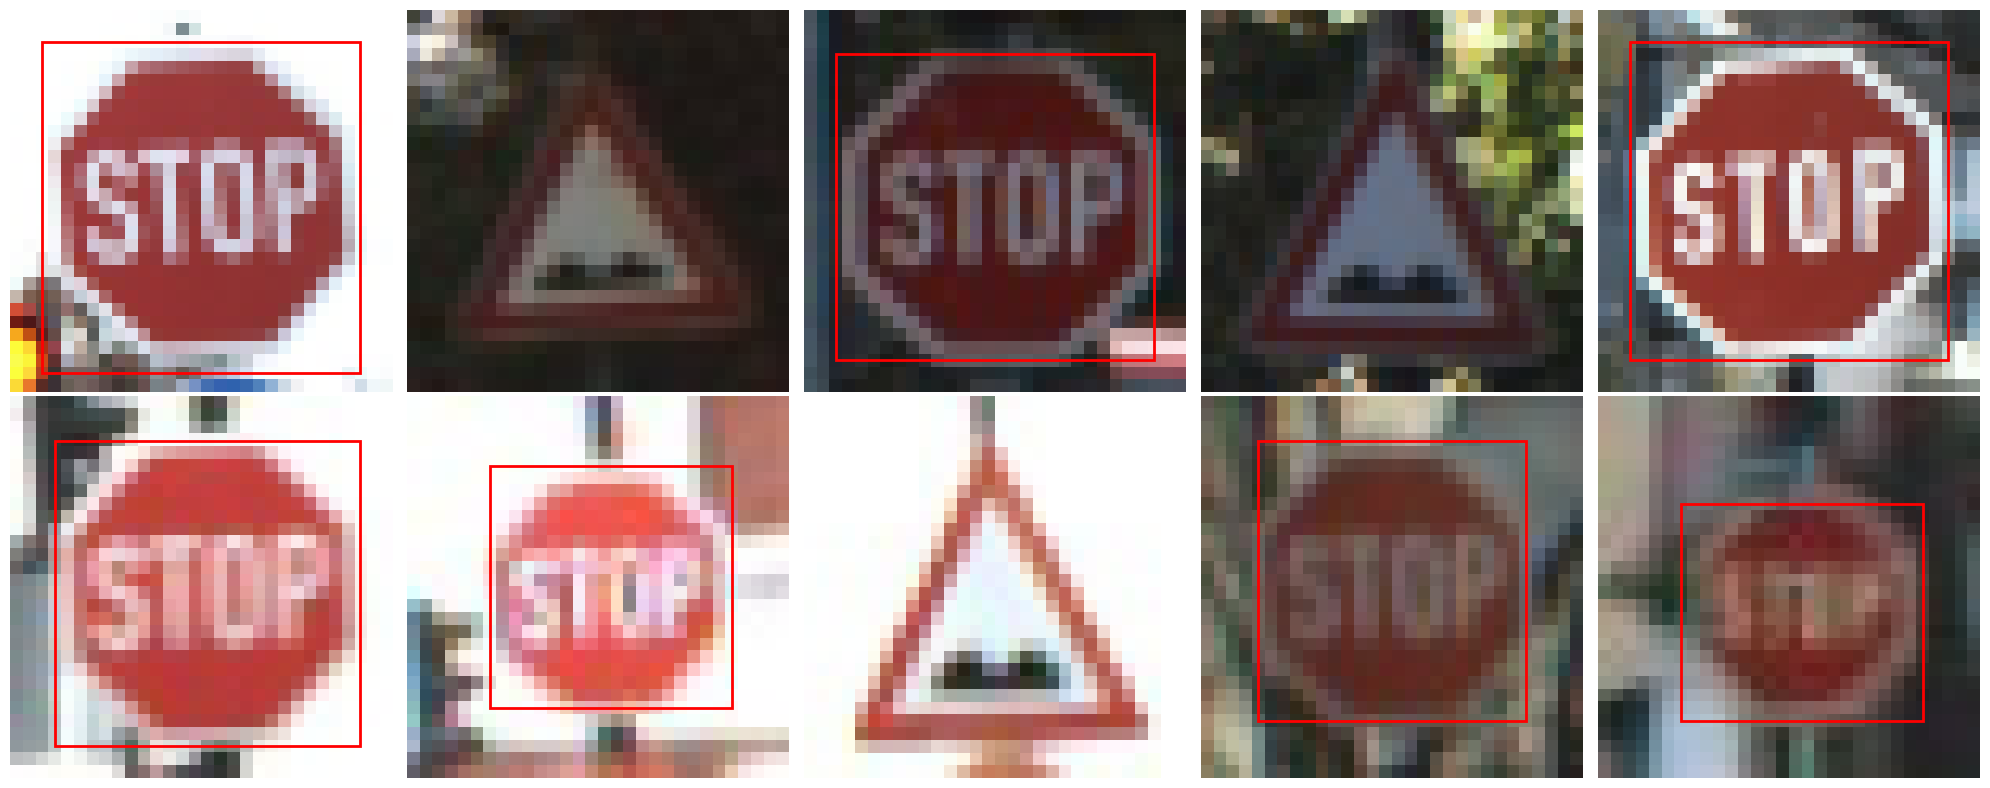

In [83]:
def visualize_samples(images, bboxes):
    """
    可视化图像及其边界框。
    :param images: 图像列表
    :param bboxes: 对应图像的边界框列表
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for img, bb, ax in zip(images, bboxes, axes):
        ax.imshow(img)
        for box in bb:
            rect = patches.Rectangle((box[0]*30, box[1]*30), box[2]*30 - box[0]*30, box[3]*30 - box[1]*30, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def read_image_list(file_path):
    with open(file_path, 'r') as file:
        return file.read().splitlines()

# 假设 train_list_path 是您的训练列表文件的路径
image_list = read_image_list(train_list_path)  # 使用实际的文件路径

# 现在您可以使用 image_list 加载数据
images, bboxes = load_data(image_list, images_path, annotations_path)

# 随机选择10个样本
sample_indices = random.sample(range(len(images)), 10)
sample_images = [images[i] for i in sample_indices]
sample_bboxes = [bboxes[i] for i in sample_indices]

# 可视化这些样本
visualize_samples(sample_images, sample_bboxes)

## making model

In [84]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler

In [85]:
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_model():
    model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.4),
    Dense(4, activation='sigmoid')  # 输出4个坐标值
    ])

    return model

model = build_model()
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 9, 9, 128)        

In [86]:
# model.compile(optimizer='adam', loss='mean_squared_error')

In [87]:
def simplify_bboxes(bboxes):
    """
    简化边界框标签，以便每个样本只有一个边界框。
    :param bboxes: 边界框标签列表
    :return: 简化后的边界框标签
    """
    simplified_bboxes = []
    for bbox_list in bboxes:
        # 检查边界框列表是否为空
        if len(bbox_list) > 0:
            simplified_bboxes.append(bbox_list[0])
        else:
            simplified_bboxes.append([0, 0, 0, 0])
    return np.array(simplified_bboxes)

train_bboxes_simplified = simplify_bboxes(train_bboxes_padded)
val_bboxes_simplified = simplify_bboxes(val_bboxes_padded)

In [88]:
lr = 0.01
epochs = 100

def scheduler(epoch, lr):
    if epoch < epochs * 0.5:
        return lr
    else:
        return lr * 0.5

lr_scheduler = LearningRateScheduler(scheduler)

opt = Adam(learning_rate=lr)

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 创建 ModelCheckpoint 回调，保存基于最高验证准确率的最佳模型
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(
    aug.flow(train_images_np, train_bboxes_simplified, batch_size=8),
    epochs=epochs,
    validation_data=(val_images_np, val_bboxes_simplified),
    callbacks=[checkpoint_cb]
)


Epoch 1/100


2023-12-03 00:36:16.547663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


117/117 [==============================] - 5s 39ms/step - loss: 0.1071 - accuracy: 0.4043 - val_loss: 0.1363 - val_accuracy: 0.4125
Epoch 2/100
117/117 [==============================] - 4s 35ms/step - loss: 0.0518 - accuracy: 0.4817 - val_loss: 0.2423 - val_accuracy: 0.0000e+00
Epoch 3/100
117/117 [==============================] - 4s 34ms/step - loss: 0.0436 - accuracy: 0.6011 - val_loss: 0.1100 - val_accuracy: 0.3792
Epoch 4/100
117/117 [==============================] - 4s 35ms/step - loss: 0.0359 - accuracy: 0.5452 - val_loss: 0.0638 - val_accuracy: 0.4167
Epoch 5/100
117/117 [==============================] - 4s 34ms/step - loss: 0.0302 - accuracy: 0.5247 - val_loss: 0.0152 - val_accuracy: 0.6500
Epoch 6/100
117/117 [==============================] - 4s 37ms/step - loss: 0.0292 - accuracy: 0.6290 - val_loss: 0.0127 - val_accuracy: 0.8750
Epoch 7/100
117/117 [==============================] - 4s 35ms/step - loss: 0.0225 - accuracy: 0.7011 - val_loss: 0.0147 - val_accuracy: 0.7583


In [90]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")

In [91]:
# 假设 val_images_np 和 val_bboxes_simplified 是您的验证图像和标签
loss, accuracy = best_model.evaluate(val_images_np, val_bboxes_simplified)

# 输出准确率
print(f"Validation accuracy: {accuracy}")


8/8 [==============================] - 0s 22ms/step - loss: 0.0127 - accuracy: 0.8750
Validation accuracy: 0.875


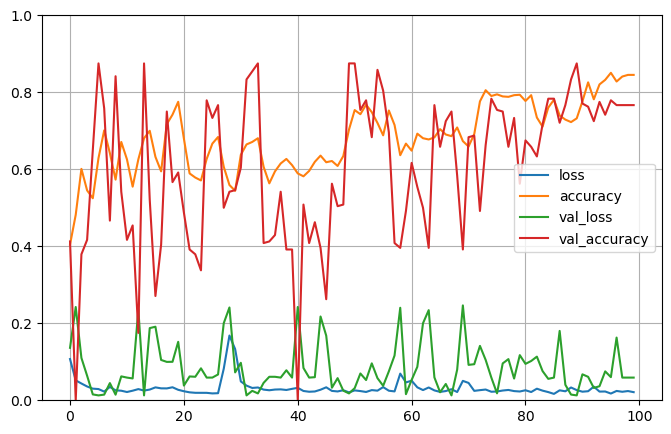

In [92]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


In [93]:
def unnormalize_bbox(bbox, img_shape):
    """
    将归一化的边界框坐标转换回原始图像尺寸。
    :param bbox: 归一化的边界框坐标 [xmin, ymin, xmax, ymax]
    :param img_shape: 图像的形状 (height, width, channels)
    :return: 转换后的边界框坐标
    """
    height, width, _ = img_shape
    xmin, ymin, xmax, ymax = bbox
    return [xmin * width, ymin * height, xmax * width, ymax * height]


1/1 [==============================] - 0s 134ms/step


/var/folders/7n/rym0b3rj47997yj8_k0ph8gh0000gn/T/ipykernel_10860/2860110012.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actual_bboxes = np.array(train_bboxes)[selected_indices]


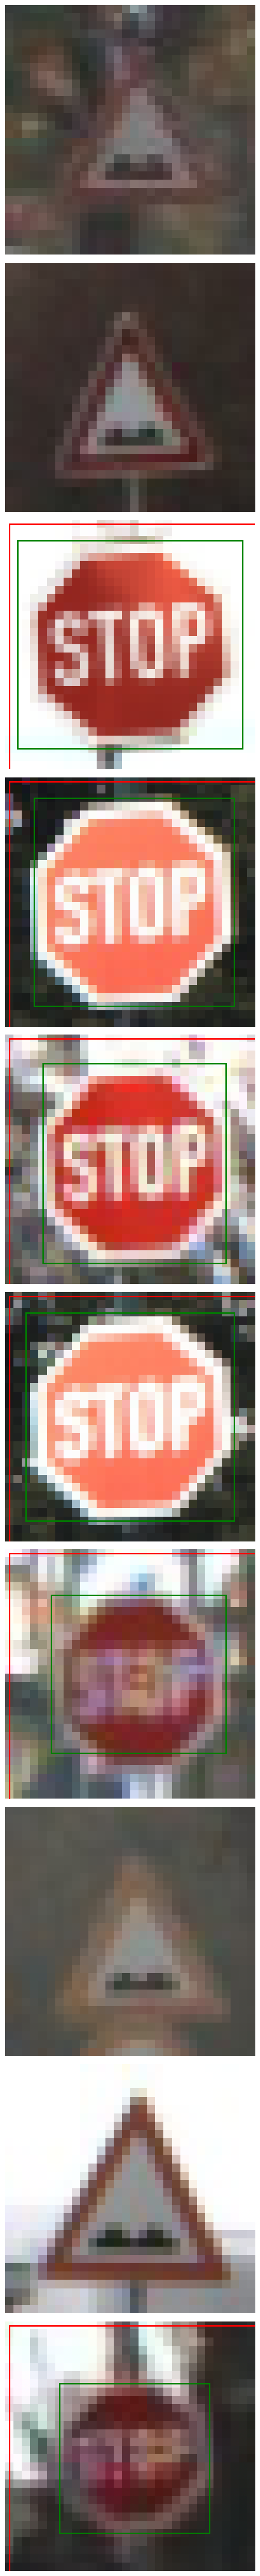

In [94]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

# 假设 train_images_np 是您的图像数据，train_bboxes 是对应的实际边界框
num_samples = 10
selected_indices = random.sample(range(len(train_images_np)), num_samples)
selected_images = train_images_np[selected_indices]
actual_bboxes = np.array(train_bboxes)[selected_indices]
predicted_bboxes = model.predict(selected_images)

def visualize_bbox_comparison(images, actual_bboxes, predicted_bboxes):
    fig, axs = plt.subplots(len(images), 1, figsize=(10, 50))
    for i, (img, actual, predicted) in enumerate(zip(images, actual_bboxes, predicted_bboxes)):
        axs[i].imshow(img)
        # 实际边界框 - 绿色
        for bbox in actual:
            unnormalized_bbox = unnormalize_bbox(bbox, img.shape)
            rect = patches.Rectangle((unnormalized_bbox[0], unnormalized_bbox[1]),
                                     unnormalized_bbox[2] - unnormalized_bbox[0],
                                     unnormalized_bbox[3] - unnormalized_bbox[1],
                                     linewidth=2, edgecolor='g', facecolor='none')
            axs[i].add_patch(rect)
        # 预测边界框 - 红色
        unnormalized_pred_bbox = unnormalize_bbox(predicted, img.shape)
        rect = patches.Rectangle((unnormalized_pred_bbox[0], unnormalized_pred_bbox[1]),
                                 unnormalized_pred_bbox[2] - unnormalized_pred_bbox[0],
                                 unnormalized_pred_bbox[3] - unnormalized_pred_bbox[1],
                                 linewidth=2, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_bbox_comparison(selected_images, actual_bboxes, predicted_bboxes)
